In [1]:
from codes.Env import Env
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import numpy as np
import gym

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
env = Env('LunarLander-v2', "./gym-results/LunarLander/random")
_ = env.run(100, policy="random")
env.display_run()

In [4]:
env = gym.make('LunarLander-v2')
print(env.observation_space)
print(env.action_space)

Box(8,)
Discrete(4)


In [5]:
class deep_policy(object):
    def __init__(self, DeepQ):
        self.DeepQ = DeepQ
    
    def __call__(self, state):
        res = self.DeepQ.predict(np.array([state]))
        return np.argmax(res)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras.optimizers import SGD
from keras.models import clone_model
from keras.optimizers import adam

Using TensorFlow backend.


In [7]:
DeepQ = Sequential()

DeepQ.add(Dense(32))
DeepQ.add(Activation('relu'))
DeepQ.add(Dense(32))
DeepQ.add(Activation('relu'))
DeepQ.add(Dense(4))
DeepQ.add(Activation('linear'))

def huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true,y_pred)
    
opt = adam(lr=0.001)
Target_Q = clone_model(DeepQ)
BestQ = clone_model(DeepQ)
DeepQ.compile(optimizer=opt, loss="mse", metrics=['mse'])

In [8]:
MAX_MEMORY = 100000
EPISODES = 1000
BATCH_SIZE = 64
DISPLAY_EPISODES = 100
DISPLAY = True
C = 10
EPSILON = 1
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.01
GAMMA = 0.99
MAX_STEP = 3000

In [9]:
env = gym.make('LunarLander-v2')
epsilon = EPSILON
Memory = []
Target_Q.set_weights(DeepQ.get_weights())
BestQ.set_weights(DeepQ.get_weights())
best_score = 0
scores = []
for e in range(EPISODES):
    done = False
    state = env.reset()
    score = 0
    for step in range(MAX_STEP):
        # EPSILON GREEDY POLICY
        if np.random.uniform() < 1-epsilon:
            action = np.argmax(DeepQ.predict(np.array([state])))
        else:
            action = env.action_space.sample()
        # OBSERVATION
        new_state, reward, done, _ = env.step(action)
        score += reward
        # TRANSITION STRORING
        if len(Memory) > MAX_MEMORY:
            Memory = Memory[1:]
        Memory.append((state, action, reward, new_state, done))
        state = new_state
        # SAMPLE MINIBATCH
        batch = [Memory[_] for _ in np.random.randint(len(Memory), size=BATCH_SIZE).tolist()]
        batch_x, batch_a, batch_r, batch_x_new, batch_done = [], [], [], [], []
        for (x, a, r, x_new, x_done) in batch:
            batch_x.append(x)
            batch_a.append(a)
            batch_r.append(r)
            batch_x_new.append(x_new)
            batch_done.append(x_done)
        batch_x, batch_r, batch_x_new = np.array(batch_x), np.array(batch_r), np.array(batch_x_new)
        # BUILD TARGET
        y = DeepQ.predict(batch_x)
        future = Target_Q.predict(batch_x_new)
        for i, (y_, a_, x_done, r) in enumerate(zip(y, batch_a, batch_done, batch_r)):
            if x_done:
                y[i, a_] = r 
            else: 
                y[i, a_] = r + GAMMA*np.max(future[i,:])
        # PERFORM ONE UPDATE
        DeepQ.fit(batch_x, y, epochs=1, batch_size=BATCH_SIZE, verbose=0)
        if done:
            scores.append(score)
            epsilon = max(epsilon*EPSILON_DECAY, MIN_EPSILON)
            break
    # UPDATE THE TARGET NETWORK
    if (e+1) % C == 0:
        print("SCORE AFTER %i EPISODES: %.2f" % (e+1, np.mean(scores[-C:])))
        Target_Q.set_weights(DeepQ.get_weights())
        if np.mean(scores[-C:]) > best_score:
            best_score = np.mean(scores[-C:]) 
            BestQ.set_weights(DeepQ.get_weights())
        
    if (e+1) % DISPLAY_EPISODES == 0 and DISPLAY:
        policy = deep_policy(DeepQ)
        test_env = Env('LunarLander-v2', "./gym-results/LunarLander/deep_train_%i" % (e+1))
        _ = test_env.run(500, policy=policy, **{})
        test_env.env.close()

SCORE AFTER 10 EPISODES: -149.96
SCORE AFTER 20 EPISODES: -187.04
SCORE AFTER 30 EPISODES: -105.39
SCORE AFTER 40 EPISODES: -118.46
SCORE AFTER 50 EPISODES: -154.89
SCORE AFTER 60 EPISODES: -98.47
SCORE AFTER 70 EPISODES: -131.49
SCORE AFTER 80 EPISODES: -62.87
SCORE AFTER 90 EPISODES: -48.80
SCORE AFTER 100 EPISODES: -72.36
SCORE AFTER 110 EPISODES: -63.88
SCORE AFTER 120 EPISODES: -57.54
SCORE AFTER 130 EPISODES: -45.56
SCORE AFTER 140 EPISODES: -76.91
SCORE AFTER 150 EPISODES: -91.70
SCORE AFTER 160 EPISODES: -70.04
SCORE AFTER 170 EPISODES: -84.49
SCORE AFTER 180 EPISODES: -59.95
SCORE AFTER 190 EPISODES: -60.81
SCORE AFTER 200 EPISODES: -69.37
SCORE AFTER 210 EPISODES: -71.82
SCORE AFTER 220 EPISODES: -102.79
SCORE AFTER 230 EPISODES: -74.64
SCORE AFTER 240 EPISODES: -59.65
SCORE AFTER 250 EPISODES: -53.41
SCORE AFTER 260 EPISODES: -66.65
SCORE AFTER 270 EPISODES: -35.19
SCORE AFTER 280 EPISODES: -61.54
SCORE AFTER 290 EPISODES: -45.16
SCORE AFTER 300 EPISODES: -67.88
SCORE AFTER 

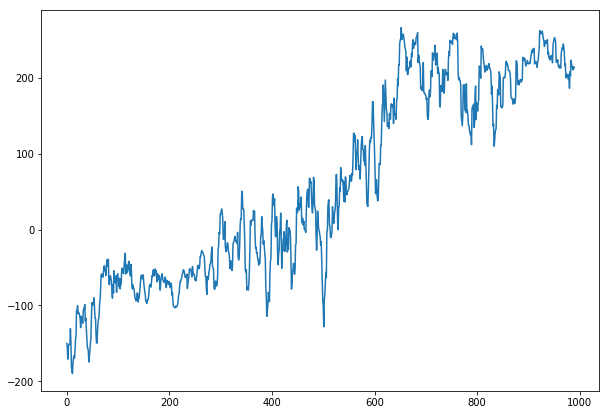

In [12]:
plt.figure(figsize=(10,7))
plt.plot([np.mean(scores[i-C:i]) for i in range(C, len(scores))])

In [15]:
policy = deep_policy(DeepQ)
env = Env('LunarLander-v2', "./gym-results/LunarLander/deep")
_ = env.run(1000, policy=policy, **{})
env.display_run()